# **Network Measurement Homework 1**

### Installing required packages and importing libraries

In [1]:
! apt-get install iputils-ping
! pip install pythonping
! pip install numpy matplotlib

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  iputils-ping
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 42.9 kB of archives.
After this operation, 116 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 iputils-ping amd64 3:20211215-1 [42.9 kB]
Fetched 42.9 kB in 0s (266 kB/s)
Selecting previously unselected package iputils-ping.
(Reading database ... 121749 files and directories currently installed.)
Preparing to unpack .../iputils-ping_3%3a20211215-1_amd64.deb ...
Unpacking iputils-ping (3:20211215-1) ...
Setting up iputils-ping (3:20211215-1) ...
Processing triggers for man-db (2.10.2-1) ...


In [2]:
import pandas as pd # To read & write csv files and use powerful dataframe features
import socket # To get IP addresses of hosts

# To define get_information() function
import urllib.request # To open url of http://ip-api.com/json/
import json # To parse the result of the request
import time # To define a random waiting time to avoid "Too many requests" error
import random #  To define a random waiting time to avoid "Too many requests" error

from pythonping import ping # For RTT measurement
from geopy.distance import geodesic #For distance calculation
from matplotlib import pyplot as plt # To plot
import numpy as np # To use polyfit and other calculations



### Reading Data & Pre-processing

The hostnames.csv includes the all host names at https://www.debian.org/mirror/list. The csv file was created by using Microsoft Excel HTML import tool. The dataset includes 335 host names from many countries.

In [10]:
# This is the path for host names
file_path = 'drive/MyDrive/NMDA/data/hostnames.csv'

# Reading the CSV file into a DataFrame
df = pd.read_csv(file_path)

# Display the DataFrame
print(df)

                               Host Name
0                   debian.unnoba.edu.ar
1                      ftp.am.debian.org
2                       mirrors.asnet.am
3                      ftp.au.debian.org
4    debian.mirror.digitalpacific.com.au
..                                   ...
330          plug-mirror.rcac.purdue.edu
331                   repo.ialab.dsu.edu
332              debian.repo.cure.edu.uy
333                mirror.bizflycloud.vn
334                      mirrors.bkns.vn

[335 rows x 1 columns]


In this part, socket is used to get the IP addresses of the hosts. The IP addresses were found because the geographic location of the hosts can be queried by their IP addresses. No error message were received. All the IP addresses were found successfully Running next cell can be skipped and loading the output can be read from "hostname_ip.csv"

In [11]:
# Defining a function to get IP address based on hostname using socket
def get_ip_address(hostname):
    try:
        ip_address = socket.gethostbyname(hostname)
        return ip_address
    except socket.error as e:
        print(f"Error: {e}")
        return 'Unknown'

# Creating a new column 'ip_addr' by applying the 'get_ip_address' function to the 'hostnames' column
df['IP Address'] = df['Host Name'].apply(get_ip_address)

# Displaying the updated DataFrame
print(df)

                               Host Name       IP Address
0                   debian.unnoba.edu.ar     200.14.116.3
1                      ftp.am.debian.org   93.187.162.100
2                       mirrors.asnet.am   93.187.162.100
3                      ftp.au.debian.org    103.84.224.37
4    debian.mirror.digitalpacific.com.au     101.0.120.90
..                                   ...              ...
330          plug-mirror.rcac.purdue.edu  128.211.151.252
331                   repo.ialab.dsu.edu  138.247.115.248
332              debian.repo.cure.edu.uy     164.73.233.2
333                mirror.bizflycloud.vn  103.107.181.186
334                      mirrors.bkns.vn   103.121.88.254

[335 rows x 2 columns]


In [13]:
# This cell is to skip running previous cell
# df.to_csv('drive/MyDrive/NMDA/data/hostname_ip.csv', index=False)
df = pd.read_csv('drive/MyDrive/NMDA/data/hostname_ip.csv')

In this part, IP addresses were used to query geographic information about hosts. The latitude and longitude were captured to calculate distances. The country and city information were kept for concluding additional information.

ip-api gives "Too many requests" error when the all IP addresses are queried. Therefore, a random waiting time is added to function, which makes long waiting time, however, it is needed to use ip-api

Avoiding to run the next cell is suggested because it approximately lasts 16 minutes. The output csv file can be loaded from "hosts_with_location.csv" in the next cell

In [14]:
# Define a function to get IP address based on hostname using socket
def get_information(ip):
        delay =  random.randint(1, 5)
        info = json.loads(urllib.request.urlopen('http://ip-api.com/json/'+ip).read())
        time.sleep(delay)
        country = info['country']
        city = info['city']
        latitude = info['lat']
        longitude = info['lon']


        return country, city, latitude, longitude


df[['Country', 'City', 'Latitude', 'Longitude']] = df['IP Address'].apply(lambda x: pd.Series(get_information(x)))
#print(get_information(df.iloc[0][1]))
df.head(10)

,Host Name,IP Address,Country,City,Latitude,Longitude
0,debian.unnoba.edu.ar,200.14.116.3,Argentina,Junín,-34.5768,-60.9470
1,ftp.am.debian.org,93.187.162.100,Armenia,Yerevan,40.2047,44.5398
2,mirrors.asnet.am,93.187.162.100,Armenia,Yerevan,40.2047,44.5398
3,ftp.au.debian.org,103.84.224.37,Australia,Sydney,-33.8688,151.2090
4,debian.mirror.digitalpacific.com.au,101.0.120.90,Australia,Sydney,-33.8688,151.2090
5,mirror.aarnet.edu.au,202.158.214.106,Australia,Canberra,-35.2298,149.1060
6,mirror.amaze.com.au,122.252.2.42,Australia,Sydney,-34.0576,151.0067
7,mirror.gsl.icu,103.1.215.35,Australia,Sydney,-33.8715,151.2006
8,mirror.linux.org.au,103.84.224.37,Australia,Sydney,-33.8688,151.2090
9,mirror.overthewire.com.au,139.5.127.195,Australia,Brisbane,-27.4669,153.0397


In [15]:
#df.to_csv('drive/MyDrive/NMDA/data/hosts_with_location.csv', index=False)
df = pd.read_csv('drive/MyDrive/NMDA/data/hosts_with_location.csv')


### Measuring RTT and Calculating Distances

Now the data is ready for measuring RTT and calculating distances. First, We retrieve our information here. Since Google Colab is used, the server and the location may be changed in different runtime sessions.

In [18]:
api='https://api.ipify.org'
my_ip = urllib.request.urlopen(api).read().decode('UTF-8')
my_country, my_city, my_latitude, my_longitude =  get_information(my_ip)
my_ip, my_country, my_city, my_latitude, my_longitude
# My info is ('35.231.19.59', 'United States', 'North Charleston', 32.8771, -80.013)

('35.231.19.59', 'United States', 'North Charleston', 32.8771, -80.013)

In [20]:
def get_RTT(ip):
  resp = ping(target=ip, count=3)
  return resp.rtt_avg*1000

df['RTT'] = df['IP Address'].apply(get_RTT)
df.head(10)

,Host Name,IP Address,Country,City,Latitude,Longitude,RTT
0,debian.unnoba.edu.ar,200.14.116.3,Argentina,Junín,-34.5768,-60.9470,130.550638
1,ftp.am.debian.org,93.187.162.100,Armenia,Yerevan,40.2047,44.5398,151.492923
2,mirrors.asnet.am,93.187.162.100,Armenia,Yerevan,40.2047,44.5398,150.440412
3,ftp.au.debian.org,103.84.224.37,Australia,Sydney,-33.8688,151.2090,200.599116
4,debian.mirror.digitalpacific.com.au,101.0.120.90,Australia,Sydney,-33.8688,151.2090,196.029141
5,mirror.aarnet.edu.au,202.158.214.106,Australia,Canberra,-35.2298,149.1060,208.291632
6,mirror.amaze.com.au,122.252.2.42,Australia,Sydney,-34.0576,151.0067,196.287551
7,mirror.gsl.icu,103.1.215.35,Australia,Sydney,-33.8715,151.2006,197.709332
8,mirror.linux.org.au,103.84.224.37,Australia,Sydney,-33.8688,151.2090,200.248172
9,mirror.overthewire.com.au,139.5.127.195,Australia,Brisbane,-27.4669,153.0397,209.061141


In [21]:
df.to_csv('drive/MyDrive/NMDA/data/hosts_with_RTT.csv', index=False)
df = pd.read_csv('drive/MyDrive/NMDA/data/hosts_with_RTT.csv')


In [22]:
# Remove rows with RTT value higher than 1999 because 2000 ms response time means timeout
df = df[df['RTT'] <= 1999]


In [23]:
# Function to calculate distance using Haversine formula
def haversine_distance(lat1, lon1, lat2, lon2):
    coords_1 = (lat1, lon1)
    coords_2 = (lat2, lon2)
    return geodesic(coords_1, coords_2).kilometers

# Calculate distances and add a new column to the DataFrame
df['Distance'] = df.apply(lambda row: haversine_distance(my_latitude, my_longitude, row['Latitude'], row['Longitude']), axis=1)
df.head(10)


,Host Name,IP Address,Country,City,Latitude,Longitude,RTT,Distance
0,debian.unnoba.edu.ar,200.14.116.3,Argentina,Junín,-34.5768,-60.9470,130.550638,7728.197555
1,ftp.am.debian.org,93.187.162.100,Armenia,Yerevan,40.2047,44.5398,151.492923,10114.653397
2,mirrors.asnet.am,93.187.162.100,Armenia,Yerevan,40.2047,44.5398,150.440412,10114.653397
3,ftp.au.debian.org,103.84.224.37,Australia,Sydney,-33.8688,151.2090,200.599116,15308.794837
4,debian.mirror.digitalpacific.com.au,101.0.120.90,Australia,Sydney,-33.8688,151.2090,196.029141,15308.794837
5,mirror.aarnet.edu.au,202.158.214.106,Australia,Canberra,-35.2298,149.1060,208.291632,15529.432414
6,mirror.amaze.com.au,122.252.2.42,Australia,Sydney,-34.0576,151.0067,196.287551,15331.791309
7,mirror.gsl.icu,103.1.215.35,Australia,Sydney,-33.8715,151.2006,197.709332,15309.620241
8,mirror.linux.org.au,103.84.224.37,Australia,Sydney,-33.8688,151.2090,200.248172,15308.794837
9,mirror.overthewire.com.au,139.5.127.195,Australia,Brisbane,-27.4669,153.0397,209.061141,14934.806339


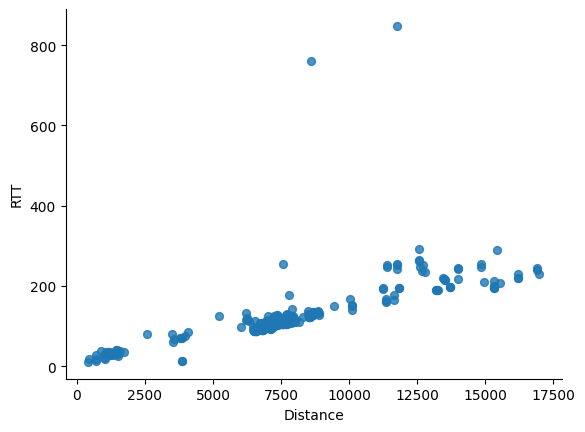

In [24]:
# @title RTT vs Distance

df.plot(kind='scatter', x='Distance', y='RTT', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

In [25]:
df.describe()

,Latitude,Longitude,RTT,Distance
count,292.000000,292.000000,292.000000,292.000000
mean,37.999080,18.397649,127.140043,7948.543984
std,24.602548,63.835448,79.095606,3414.947416
min,-45.882500,-123.192400,10.736558,418.596227
25%,38.862425,2.277197,97.857003,6868.534689
50%,47.244550,12.340150,111.037123,7369.871780
75%,51.115650,28.039050,129.903040,8575.873016
max,64.151400,174.793200,848.051007,16972.018893


In [26]:
# Find the index of the row with the minimum RTT
min_rtt_index = df['RTT'].idxmin()
# Extract the row with the minimum RTT
row_with_min_rtt = df.loc[min_rtt_index]

# Find the index of the row with the minimum Distance
min_distance_index = df['Distance'].idxmin()
# Extract the row with the minimum Distance
row_with_min_distance = df.loc[min_distance_index]

# Find the index of the row with the maximum RTT
max_rtt_index = df['RTT'].idxmax()
# Extract the row with the maximum RTT
row_with_max_rtt = df.loc[max_rtt_index]

# Find the index of the row with the maximum Distance
max_distance_index = df['Distance'].idxmax()
# Extract the row with the maximum Distance
row_with_max_distance = df.loc[max_distance_index]

# Print the results
print("Row with minimum RTT:")
print(row_with_min_rtt)

print("\nRow with minimum Distance:")
print(row_with_min_distance)

print("\nRow with maximum RTT:")
print(row_with_max_rtt)

print("\nRow with maximum Distance:")
print(row_with_max_distance)


Row with minimum RTT:
Host Name     atl.mirrors.clouvider.net
IP Address                92.119.16.152
Country                   United States
City                            Atlanta
Latitude                        33.7485
Longitude                      -84.3871
RTT                           10.736558
Distance                     418.596227
Name: 303, dtype: object

Row with minimum Distance:
Host Name     atl.mirrors.clouvider.net
IP Address                92.119.16.152
Country                   United States
City                            Atlanta
Latitude                        33.7485
Longitude                      -84.3871
RTT                           10.736558
Distance                     418.596227
Name: 303, dtype: object

Row with maximum RTT:
Host Name     mirrors.huaweicloud.com
IP Address             124.70.125.167
Country                         China
City                          Beijing
Latitude                      39.9042
Longitude                    116.4073
RTT      

### Approximation for RTT

Average RTT per km: 0.014890105987342646


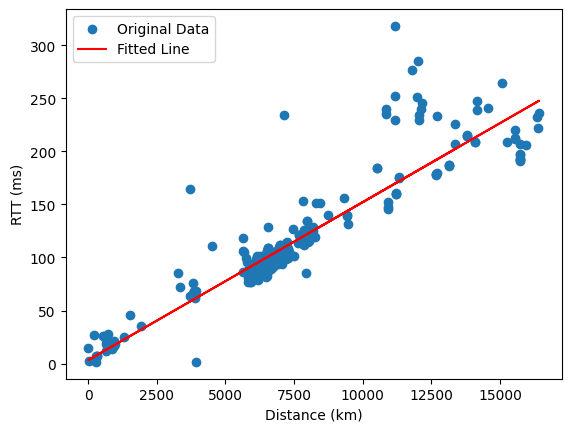

In [112]:

# Fit a linear function using numpy.polyfit
coefficients = np.polyfit(df['Distance'], df['RTT'], deg=1)

# Extract the slope and intercept from the coefficients
slope, intercept = coefficients

# Print the slope (average RTT per km)
print("Average RTT (ms) per km:", slope)

# Plot the original data and the fitted linear function (optional)
plt.scatter(df['Distance'], df['RTT'], label='Original Data')
plt.plot(df['Distance'], slope * df['Distance'] + intercept, color='red', label='Fitted Line')
plt.xlabel('Distance (km)')
plt.ylabel('RTT (ms)')
plt.legend()
plt.show()
